In [1]:
import os
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"

In [3]:
#you can get this table from the SCAN dryad link
info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)
info_df

,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,Country,Locality,Latitude,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,angola_cota_57,MCF03050E0612,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907442,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,76.6,32.96,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
1,angola_cota_58,MCF03050E0613,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907441,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,71.6,32.83,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
2,angola_cota_59,MCF03050E0614,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907440,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,66.5,25.61,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
3,angola_icau_60,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907439,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,56.7,25.73,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
4,angola_icau_61,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907438,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,75.3,30.40,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,margrebowiei_zambia_ERR310940,"NHM3239,40",S. margrebowiei,Na,Na,ERR310940,Coghlan et al. (2018),Zambia,Lochinvar,Na,...,miracidia,adult worm (lab),152.2,33.72,True,NaN,Na,SCAN,SCAN,Data generated as part of the 50 Helminth Geno...
210,zambia_kafue_69,MCF03050E0836,S. haematobium,Na,Na,SRR11907433,Herein,Zambia,Kafue,-15.783442,...,miracidia,miracidia,93.9,9.25,False,NaN,Na,SCAN,CONTRAST,NaN
211,zambia_kafue_71,MCF03050E0843,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907431,Herein,Zambia,Kafue,-15.783442,...,cercariae,cercariae,88.5,43.49,True,NaN,100.00%,SCAN,CONTRAST,NaN
212,zambia_lishiko_66,MCF03050E0808,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907434,Herein,Zambia,Lishiko school,-15.74499,...,miracidia,miracidia,74.6,12.63,True,NaN,100.00%,SCAN,CONTRAST,NaN


# Prep Raw Data

In [5]:
os.chdir(f"{proj_dir}/data")

In [6]:
wget https://datadryad.org/downloads/file_stream/3964907

## Filter the VCF file

In [30]:
Path(f"{results_dir}/prep_vcf").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/prep_vcf")

In [15]:
info_df.columns

Index(['Library ID', 'Museum Accession Number (NHM) or Donor ID',
       'Predicted Species', 'Mitchondrial Haplotype', 'Population Assignment',
       'NCBI SRA Accession', 'Project Citation', 'Country', 'Locality',
       'Latitude', 'Longitude', 'Collection Date', 'Collection Host',
       'Original life-cycle stage collected', 'Life-cycle stage sequenced ',
       'Num Read Pairs (1e6)', 'Coverage', 'Final SNV Dataset',
       'Discordant COX1/ITS', '% S. haematobium ancestry (q)', 'Origin',
       'Project (Collector)', 'Comments'],
      dtype='object')

In [246]:
#which samples to exclude
info_df.loc[info_df["Final SNV Dataset"] == True]["Library ID"].to_csv("samples.include.list", sep=",", header=False, index=False)
!cat samples.include.list | wc -l

163


In [14]:
info_df.loc[info_df["Final SNV Dataset"] == True, "Predicted Species"].value_counts()

Predicted Species
S. haematobium     141
S. bovis            21
S. margrebowiei      1
Name: count, dtype: int64

In [16]:
info_df.loc[info_df["Final SNV Dataset"] == True, "Population Assignment"].value_counts()

Population Assignment
S. haematobium (northern)    82
S. haematobium (southern)    59
S. bovis                     21
Na                            1
Name: count, dtype: int64

In [ ]:
conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \

In [ ]:
conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --maf 0.05 \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \

In [9]:
%%bash

conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --maf 0.05 \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --keep samples.include.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >autosomes_maf05.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
/../data/scan_snvs.vcf.gz
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
1--chr NC_067199.
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--keep samples.include.list
FO-allode-IN
	--maf 0.05
	--recode
	--stdout

Using zlib version: 1.3.1
ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the sa

In [10]:
%%bash

conda run -n popgen --live-stream \
    plink2 \
        --vcf autosomes_maf05.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out ld

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to ld.log.
Options in effect:
allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out ld
  --vcf autosomes_maf05.vcf

tart time: Thu Mar  6 17:53:57 2025
iB for main RAM detected, ~1017340 available; reserving 515643 M
workspace.
Using up to 192 threads (change this with --threads).
--vcf: 5972982 variants scanned.
--vcf: ld-temporary.pgen + ld-temporary.pvar.zst + ld-temporary.psam written.
s, 0 males, 163 ambiguous; 163 founders) loaded from
ld-temporary.psam.
 ld-temporary.pvar.zst. from
Note: No phenotype data present.
done.lating allele frequencies... 0%
5591481/5972982 variants removed.ds): 0%
Variant lists written to ld.prune.in and ld.prune.out .
End time: Thu Mar  6 17:54:58 2025


In [ ]:
%%bash

conda run -n vcftools --live-stream \
    vcftools \
        --vcf scan_autosomes_maf05_ld_w_smarg.vcf \
        --exclude ld.prune.out \
        --recode \
        --recode-INFO-all \
        --stdout \
        >scan_autosomes_maf05_ld_w_smarg.vcf

echo "snv_id" >all_snvs.list; grep -v "#" scan_autosomes_maf05_ld.vcf | cut -f3 >>all_snvs.list

In [247]:
%%bash

conda run -n vcftools --live-stream \
    vcftools \
        --vcf scan_autosomes_maf05_ld_w_smarg.vcf \
        --remove-indv margrebowiei_zambia_ERR310940 \
        --recode \
        --recode-INFO-all \
        --stdout \
        >scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
_autosomes_maf05_ld_w_smarg.vcf
	--recode-INFO-all
	--recode
	--stdout
ambia_ERR310940margrebowiei_z

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each ALT allele, 

In [248]:
sh_s_list = info_df.loc[((info_df["Final SNV Dataset"] == True) & (info_df["Population Assignment"] == "S. haematobium (southern)")), "Library ID"]
sh_n_list = info_df.loc[((info_df["Final SNV Dataset"] == True) & (info_df["Population Assignment"] == "S. haematobium (northern)")), "Library ID"]
sb_list = info_df.loc[((info_df["Final SNV Dataset"] == True) & (info_df["Population Assignment"] == "S. bovis")), "Library ID"]

sh_s_list.to_csv("sh_s.list", sep=",", header=False, index=False)
sh_n_list.to_csv("sh_n.list", sep=",", header=False, index=False)
sb_list.to_csv("sb.list", sep=",", header=False, index=False)

!cat sh_s.list sh_n.list >sh.list

# PCA

In [249]:
Path(f"{results_dir}/pca").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/pca")

In [250]:
%%bash
conda run -n popgen --cwd . --live-stream\
    plink2 \
        --threads 12 \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --pca 10 biallelic-var-wts \
        --double-id \
        --allow-extra-chr \
        --out pca

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to pca.log.
Options in effect:
-allow-extra-chr
  --double-id
  --out pca
  --pca 10 biallelic-var-wts
  --threads 12
ep_vcf/scan_autosomes_maf05_ld.vcf

Start time: Wed Mar 19 15:45:42 2025
1010006 available; reserving 515643 MiB for main
workspace.
 --threads).12 threads (change this with
--vcf: 381501 variants scanned.
--vcf: pca-temporary.pgen + pca-temporary.pvar.zst + pca-temporary.psam
written.
ales, 0 males, 162 ambiguous; 162 founders) loaded from
pca-temporary.psam.
rom pca-temporary.pvar.zst.
Note: No phenotype data present.
done.lating allele frequencies... 0%
done.ructing GRM: 0%
done.cting for missingness... 0%
done.cting eigenvalues and eigenvectors... 
--pca: Variant weights written to pca.eigenvec.var .
ec , and eigenvalues written topca.eigenv
pca.eigenval .
End time: Wed Mar 19 15:45:48 2025


In [251]:
#get eigen values and sample labels
pca_df=pd.read_csv("pca.eigenvec", sep="\t", header=0)
pca_df=pca_df.drop("#FID", axis=1)

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', left_on="IID", right_on='Library ID')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["Country"].astype(str)

countries = sorted(pca_df["country"].unique().astype(str))
pca_df.to_csv("pca_df.csv", sep=",", header=True, index=False)
pca_df


,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments,country
0,NG_au_1.2,-0.198091,0.036822,0.000107,0.008080,0.000912,-0.003231,-0.007941,-0.016540,-0.000501,...,adult worm (natural),55.6,20.53,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
1,NG_au_2.10,-0.197004,0.036031,0.000144,0.009087,0.000689,-0.001825,-0.009265,-0.014317,-0.000846,...,adult worm (natural),52.1,23.15,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
2,NG_au_2.13,-0.197794,0.036400,-0.000267,0.005518,0.001174,-0.000598,-0.011046,-0.015342,-0.001355,...,adult worm (natural),53.0,23.30,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
3,NG_au_2.5,-0.197056,0.036287,0.001327,0.002108,0.001794,-0.000134,-0.006769,-0.007782,-0.001760,...,adult worm (natural),58.1,24.73,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
4,NG_au_2.6,-0.195994,0.036494,-0.000507,0.009166,0.001586,-0.001477,-0.008578,-0.021445,-0.005553,...,adult worm (natural),62.6,27.05,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,niger_libore_166,0.018468,-0.080543,-0.019165,-0.068737,0.016234,-0.087350,-0.031851,-0.041734,0.025669,...,cercariae,81.6,41.80,True,NaN,96.11%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
158,niger_libore_167,0.019727,-0.080046,-0.008709,-0.064440,0.026300,-0.069191,-0.002711,-0.011218,-0.061353,...,cercariae,63.2,31.23,True,NaN,95.97%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
159,niger_libore_168,0.018089,-0.078732,-0.017259,-0.061916,0.005263,-0.041375,-0.001108,-0.060964,-0.036833,...,cercariae,72.4,39.19,True,NaN,95.78%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
160,niger_libore_169,0.019798,-0.074796,-0.018525,-0.053582,0.014292,-0.057004,0.004988,-0.015387,-0.036947,...,cercariae,95.9,50.42,True,NaN,95.79%,SCAN,SCORE Niger non-SCORE site,NaN,Niger


In [252]:
load_df = pd.read_csv("pca.eigenvec.var", sep="\t", header=0)
load_df

,#CHROM,ID,MAJ,NONMAJ,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,NC_067196.1,NC_067196.1:124178,G,A,-0.000532,-0.708673,-0.720289,-1.313350,0.263159,-2.031470,-0.500836,-1.586570,-1.754970,1.677510
1,NC_067196.1,NC_067196.1:124348,C,T,-1.438080,0.145945,0.021752,-0.285699,-0.079164,0.818276,0.063099,0.402947,0.000189,-0.312032
2,NC_067196.1,NC_067196.1:147062,C,T,0.011429,0.333975,-1.471570,-0.991169,-1.180790,-0.280280,-0.373912,-0.441487,-0.322155,1.050420
3,NC_067196.1,NC_067196.1:147068,A,G,-0.063247,0.404833,1.349920,-0.469258,-3.299020,-0.300788,-0.428815,-0.957695,2.460220,0.192438
4,NC_067196.1,NC_067196.1:147073,T,C,0.128191,-0.630096,-0.310258,-1.174120,-0.027830,-0.538503,-0.088496,1.066520,-1.278360,0.778360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381496,NC_067202.1,NC_067202.1:19477842,G,A,0.427294,1.221910,-0.715132,-0.377942,1.330870,0.574784,-0.304845,0.564274,0.849701,0.230567
381497,NC_067202.1,NC_067202.1:19478168,G,A,-1.257370,0.410234,0.000546,-0.364212,0.160536,0.039711,0.246028,-0.317249,-0.437961,0.348546
381498,NC_067202.1,NC_067202.1:19478217,T,C,0.351508,-0.312768,1.136180,0.461802,-1.223220,-0.062090,-0.495896,0.200838,0.973146,-0.158009
381499,NC_067202.1,NC_067202.1:19478231,C,A,0.248832,1.104460,-2.055770,-0.552074,-2.131810,0.264587,0.143844,0.009867,-1.336000,-0.270342


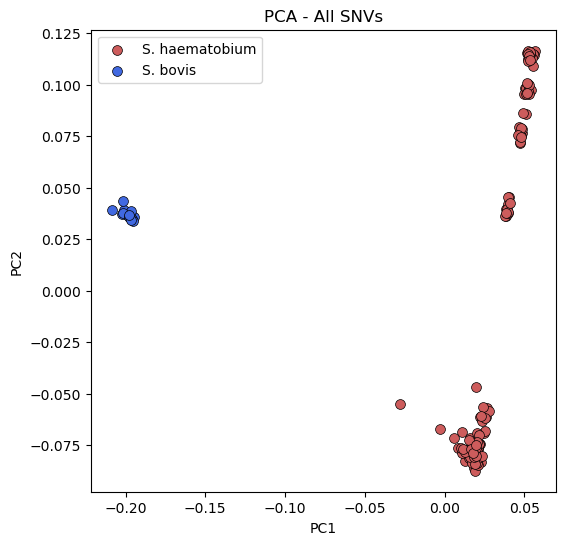

In [254]:
import matplotlib.pyplot as plt
import yaml
import pandas as pd

# Define directories
proj_dir = "/master/nplatt/schisto_aim_panel"
results_dir = f"{proj_dir}/results"

# Load data
info_df = pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",")
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")

# Load YAML config
with open(f"{proj_dir}/code/plotting_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for each species
for species in ["S. haematobium", "S. bovis"]:
    all_snv_data = all_snvs_df[all_snvs_df["Predicted Species"] == species]
    ax.scatter(
        all_snv_data["PC1"],
        all_snv_data["PC2"],
        color=config["species"][species]["color"],
        edgecolor="black",
        s=50,
        linewidths=0.5,
        label=species
    )

# Set axis labels, title, and legend
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA - All SNVs")
ax.legend()

# Save the figure
plt.savefig("wg.pca.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig("wg.pca.svg")

# Show plot
plt.show()

# SubSample variants

In [34]:
Path(f"{results_dir}/subsample_snvs").mkdir(parents=True, exist_ok=True)
Path(f"{results_dir}/fst").mkdir(parents=True, exist_ok=True)

os.chdir(f"{results_dir}/subsample_snvs")

In [7]:
target_n_snvs = [1_000, 500, 250, 200, 150, 100, 75, 50, 40, 30, 20, 10] 

## Subsample from all MAF05 LD variants

In [262]:
import os
import numpy as np
import pandas as pd

# Set project and result directories
proj_dir = "/master/nplatt/schisto_aim_panel"
results_dir = f"{proj_dir}/results"
os.chdir(f"{results_dir}/subsample_snvs")

# Define constants
input_vcf = f"{results_dir}/prep_vcf/scan_autosomes_maf05_ld.vcf"
input_sh_list = f"{results_dir}/prep_vcf/sh.list"
input_sb_list = f"{results_dir}/prep_vcf/sb.list"
input_south_list = f"{results_dir}/prep_vcf/sh_s.list"
input_north_list = f"{results_dir}/prep_vcf/sh_n.list"
output_fst_dir = f"{results_dir}/fst"


all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca.eigenvec.var", sep="\t", header=0)
target_n_snvs = [100_000, 1_000, 500, 250, 200, 150, 100, 75, 50, 40, 30, 20, 10] 
replicates = 100

# Loop over PCA types
for pca_type in ["all"]:
    
    # Loop over target SNV counts and replicates
    for n_snvs in target_n_snvs:
        for rep in range(replicates):
            
            # Define filenames
            run_name = f"{pca_type}.subsample_n{n_snvs}_rep{rep}"
            output_snv_list = f"{run_name}.list"
            output_vcf = f"{run_name}.vcf"
            output_plink = run_name
            output_stdout = f"{run_name}.stdout"
            output_stderr = f"{run_name}.stderr"
            output_sge = f"{run_name}.sge.sh"

            # Sample SNVs
            random_seed = np.random.randint(0, 99999)
            sampled_snvs = all_snvs_df["ID"].sample(n=n_snvs, random_state=random_seed)
            sampled_snvs.to_csv(output_snv_list, index=False, header=False)

            # Build SGE shell script
            cmd = f"""#!/bin/bash
#$ -V
#$ -cwd
#$ -S /bin/bash
#$ -q all.q
#$ -pe smp 1
#$ -N {run_name}
#$ -o {output_stdout}
#$ -e {output_stderr}

conda run -n popgen --live-stream --cwd . vcftools --vcf {input_vcf} --snps {output_snv_list} --recode --recode-INFO-all --stdout > {output_vcf}

sleep 10s

conda run -n popgen --live-stream --cwd . plink2 --threads 1 --vcf {output_vcf} --pca 10 --double-id --allow-extra-chr --out {output_plink}
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_south_list} --weir-fst-pop {input_north_list} --vcf {output_vcf} --out {output_fst_dir}/south_v_north.{run_name} >{output_fst_dir}/south_v_north.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_south_list} --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/south_v_sbov.{run_name} >{output_fst_dir}/south_v_sbov.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_north_list} --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/north_v_sbov.{run_name} >{output_fst_dir}/north_v_sbov.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_sh_list}   --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/shae_v_sbov.{run_name} >{output_fst_dir}/shae_v_sbov.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_south_list} --weir-fst-pop {input_north_list} --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/global.{run_name} >{output_fst_dir}/global.{run_name}.log 2>&1     

sleep 10s

"""

            # Write shell script to file
            with open(output_sge, "w") as f:
                f.write(cmd)

            # Submit job
            os.system(f"qsub {output_sge}")


Your job 1465319 ("all.subsample_n100000_rep0") has been submitted
Your job 1465320 ("all.subsample_n100000_rep1") has been submitted
Your job 1465321 ("all.subsample_n100000_rep2") has been submitted
Your job 1465322 ("all.subsample_n100000_rep3") has been submitted
Your job 1465323 ("all.subsample_n100000_rep4") has been submitted
Your job 1465324 ("all.subsample_n100000_rep5") has been submitted
Your job 1465325 ("all.subsample_n100000_rep6") has been submitted
Your job 1465326 ("all.subsample_n100000_rep7") has been submitted
Your job 1465327 ("all.subsample_n100000_rep8") has been submitted
Your job 1465328 ("all.subsample_n100000_rep9") has been submitted
Your job 1465329 ("all.subsample_n100000_rep10") has been submitted
Your job 1465330 ("all.subsample_n100000_rep11") has been submitted
Your job 1465331 ("all.subsample_n100000_rep12") has been submitted
Your job 1465332 ("all.subsample_n100000_rep13") has been submitted
Your job 1465333 ("all.subsample_n100000_rep14") has been 

In [263]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
import glob

# Set environment variables
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"
os.chdir(f"{results_dir}/subsample_snvs")

target_n_snvs = [100_000, 1_000, 500, 250, 200, 150, 100, 75, 50, 40, 30, 20, 10] 
replicates = 100

procrustes_distances=[]
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")
failed = "failed.pca.log"

with open(failed, 'a') as out:
    out.write(f"snv_type,n_snvs,rep")
    
for snv_type in ["all"]:
    for n_snvs in target_n_snvs:
        for rep in list(range(0, replicates)):
            try:
                #input
                eigenvec_file = f"{snv_type}.subsample_n{n_snvs}_rep{rep}.eigenvec"
                target_pca_df = pd.read_csv(eigenvec_file, sep="\t", header=0)

                #output
                png=eigenvec_file.replace("eigenvec", "pca.png")
                svg=png.replace("png", "svg")
                
                # Extract PC1 and PC2 coordinates from your dataframes
                X = all_snvs_df[["PC1", "PC2"]].to_numpy()
                Y = target_pca_df[["PC1", "PC2"]].to_numpy()
                        
                # Ensure both datasets have the same number of points
                if X.shape != Y.shape:
                    raise ValueError(f"Shapes of X {X.shape} and Y {Y.shape} must be the same for Procrustes analysis.")
                
                # Perform Procrustes analysis
                m1, m2, disparity = procrustes(X, Y)
                        
                # get Procrustes distance
                procrustes_distances.append([snv_type, n_snvs, rep, disparity])
                        
                # Plot the original scatter plots
                fig, axs = plt.subplots(1, 2, figsize=(12, 5))
                        
                # Original Scatter Plots
                axs[0].scatter(X[:, 0], X[:, 1], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
                axs[0].scatter(Y[:, 0], Y[:, 1], label=f"n={n_snvs}, rep={rep}", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
                axs[0].set_title("Original Scatter Plots")
                axs[0].legend()
                        
                # Aligned Scatter Plots after Procrustes transformation
                axs[1].scatter(m1[:, 0], m1[:, 1], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
                axs[1].scatter(m2[:, 0], m2[:, 1], label=f"n={n_snvs}, rep={rep}", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
                axs[1].set_title("Procrustes Aligned Scatter Plots")
                axs[1].legend()
                        
                # Save the figure
                plt.savefig(png, facecolor="white", dpi=600, bbox_inches="tight")
                plt.savefig(svg)
                plt.close()

            except:
                with open(failed, 'a') as out:
                    out.write(f"{snv_type},{n_snvs},{rep}")
                    
# Convert results to a DataFrame and save
procrustes_df = pd.DataFrame(procrustes_distances, columns=["snv_type", "n_snvs", "replicate", "m2"])
procrustes_df.to_csv("procrustes.csv", index=False, header=True, sep=",")

In [10]:
!pwd

/master/nplatt/schisto_aim_panel/results/subsample_snvs


In [37]:
procrustes_df["t0_similarity"] = np.sqrt(1 - procrustes_df["procrustes_distance"])
procrustes_df.to_csv("procrustes.csv", index=False, header=True, sep=",")
procrustes_df

,snv_type,n_snvs,replicate,procrustes_distance,t0_similarity
0,all,100000,0,0.000035,0.999982
1,all,100000,1,0.000031,0.999985
2,all,100000,2,0.000040,0.999980
3,all,100000,3,0.000039,0.999980
4,all,100000,4,0.000037,0.999982
...,...,...,...,...,...
1238,all,10,93,0.320609,0.824252
1239,all,10,94,0.152007,0.920866
1240,all,10,95,0.320609,0.824252
1241,all,10,96,0.339673,0.812605


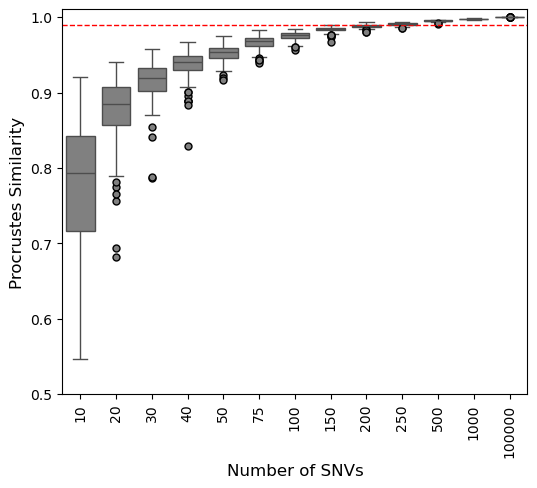

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot grouped by 'n_snvs' using 'procrustes_distance' as values
plt.figure(figsize=(6, 5))
sns.boxplot(x="n_snvs", 
            y="t0_similarity", 
            data=procrustes_df.loc[procrustes_df["n_snvs"]>=10],
            color="grey",
            flierprops=dict(marker='o', markerfacecolor='grey', markeredgecolor='black', markersize=5, linestyle="none")
           )
# Set labels and title
plt.xlabel("Number of SNVs", fontsize=12)
plt.xticks(rotation=90)
plt.ylabel("Procrustes Similarity", fontsize=12)
#plt.title("Boxplot of Procrustes Distance by Number of SNVs", fontsize=14)
plt.ylim(0.5, 1.01)
plt.axhline(y=0.99, color='red', linestyle='--', linewidth=1)

# Adjust layout
# plt.tight_layout()

# Save the figure
plt.savefig(f"all.t0.procrustes.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig(f"all.t0.procrustes.svg")

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot grouped by 'n_snvs' using 'procrustes_distance' as values
plt.figure(figsize=(6, 5))
sns.boxplot(x="n_snvs", 
            y="procrustes_distance", 
            data=procrustes_df.loc[procrustes_df["n_snvs"]>=10],
            color="grey",
            flierprops=dict(marker='o', markerfacecolor='grey', markeredgecolor='black', markersize=5, linestyle="none")
           )
# Set labels and title
plt.xlabel("Number of SNVs", fontsize=12)
plt.xticks(rotation=90)
plt.ylabel("Procrustes Distance", fontsize=12)
#plt.title("Boxplot of Procrustes Distance by Number of SNVs", fontsize=14)

plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1)

# Adjust layout
# plt.tight_layout()

# Save the figure
plt.savefig(f"all.procrustes.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig(f"all.procrustes.svg")

# Show the plot
plt.show()


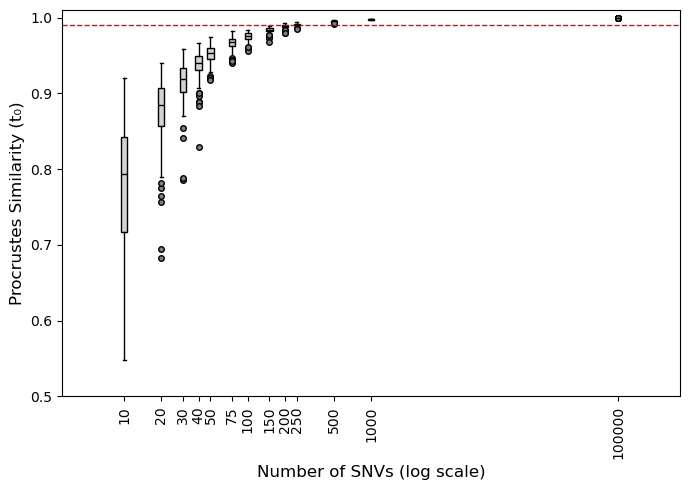

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define unique SNV values (x locations on log scale)
snv_values = sorted(procrustes_df["n_snvs"].unique())
x_positions = np.log10(snv_values)  # use log10 or log2 depending on preference

# Prepare boxplot data manually
box_data = [procrustes_df.loc[procrustes_df["n_snvs"] == n, "t0_similarity"] for n in snv_values]

plt.figure(figsize=(7, 5))
bplot = plt.boxplot(box_data, 
                    positions=x_positions,
                    patch_artist=True,
                    widths=0.05,  # control width of boxes on log scale
                    boxprops=dict(facecolor='lightgrey', color='black'),
                    flierprops=dict(marker='o', markerfacecolor='grey', markeredgecolor='black', markersize=4, linestyle='none'),
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black')
                   )

# Customize x-axis with real SNV values as tick labels
plt.xticks(x_positions, snv_values, rotation=90)
plt.xlabel("Number of SNVs (log scale)", fontsize=12)
plt.ylabel("Procrustes Similarity (t₀)", fontsize=12)
plt.ylim(0.5, 1.01)
plt.axhline(y=0.99, color='red', linestyle='--', linewidth=1)
plt.tight_layout()

# Save and show
plt.savefig("logscale_procrustes_similarity.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.savefig("logscale_procrustes_similarity.svg")
plt.show()


In [38]:
procrustes_df = pd.read_csv("procrustes.csv", header=0, sep=",")
procrustes_df

,snv_type,n_snvs,replicate,procrustes_distance,t0_similarity
0,all,100000,0,0.000035,0.999982
1,all,100000,1,0.000031,0.999985
2,all,100000,2,0.000040,0.999980
3,all,100000,3,0.000039,0.999980
4,all,100000,4,0.000037,0.999982
...,...,...,...,...,...
1238,all,10,93,0.320609,0.824252
1239,all,10,94,0.152007,0.920866
1240,all,10,95,0.320609,0.824252
1241,all,10,96,0.339673,0.812605


In [39]:
summary = procrustes_df.groupby("n_snvs")["t0_similarity"].agg(
    mean="mean",
    median="median",
    min="min",
    max="max",
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
    n_obs="count"
).reset_index()

summary

,n_snvs,mean,median,min,max,IQR,n_obs
0,10,0.770916,0.793854,0.495483,0.920866,0.125973,48
1,20,0.874323,0.885191,0.682691,0.940579,0.049865,95
2,30,0.913954,0.918579,0.786162,0.957920,0.031332,100
3,40,0.936452,0.940318,0.828753,0.966378,0.018688,100
4,50,0.951793,0.953862,0.917026,0.974761,0.014165,100
5,75,0.966051,0.968193,0.939751,0.982289,0.009970,100
6,100,0.974944,0.975902,0.955961,0.984076,0.007106,100
7,150,0.983630,0.984045,0.967365,0.989149,0.003754,100
8,200,0.988257,0.988359,0.979811,0.993124,0.002333,100
9,250,0.990582,0.990694,0.985043,0.993634,0.001922,100


# plot fst results

In [135]:
Path(f"{results_dir}/fst").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/fst")

In [ ]:
%%bash

#get all of the fst values into a single csv to be imported to a df
echo "comp,n_snvs,rep,fst">fsts.csv
grep "Weir and Cockerham weighted Fst estimate:" *log | cut -f1,3 -d":" | sed 's/.log: /,/' | sed 's/.all.subsample_n/,/' | sed 's/_rep/,/' >>fsts.csv


In [138]:
fst_df = pd.read_csv("fsts.csv", sep=",", header=0)
fst_df

,comp,n_snvs,rep,fst
0,global,1000,0,0.41947
1,global,1000,10,0.42053
2,global,1000,11,0.42399
3,global,1000,12,0.42573
4,global,1000,13,0.44029
...,...,...,...,...
12495,south_v_sbov,90,96,0.71330
12496,south_v_sbov,90,97,0.71867
12497,south_v_sbov,90,98,0.67562
12498,south_v_sbov,90,99,0.70638


In [142]:
%%bash

#get fst from the full dataset
conda run -n popgen --live-stream --cwd . \
    vcftools \
        --weir-fst-pop ../prep_vcf/sh.list \
        --weir-fst-pop ../prep_vcf/sb.list \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--weir-fst-pop ../prep_vcf/sh.list
sb.list-fst-pop ../prep_vcf/
	--keep ../prep_vcf/sh.list
	--keep ../prep_vcf/sb.list

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the

In [172]:
%%bash

#get fst from the full dataset
conda run -n popgen --live-stream --cwd . \
    vcftools \
        --weir-fst-pop ../prep_vcf/sh_n.list \
        --weir-fst-pop ../prep_vcf/sh_s.list \
        --weir-fst-pop ../prep_vcf/sb.list \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--weir-fst-pop ../prep_vcf/sh_n.list
f/sh_s.list-pop ../prep_vc
	--weir-fst-pop ../prep_vcf/sb.list
	--keep ../prep_vcf/sh_n.list
_s.list ../prep_vcf/sh
	--keep ../prep_vcf/sb.list

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Flo

In [173]:
%%bash

#get fst from the full dataset
conda run -n popgen --live-stream --cwd . \
    vcftools \
        --weir-fst-pop ../prep_vcf/sh_n.list \
        --weir-fst-pop ../prep_vcf/sh_s.list \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--weir-fst-pop ../prep_vcf/sh_n.list
f/sh_s.list-pop ../prep_vc
	--keep ../prep_vcf/sh_n.list
	--keep ../prep_vcf/sh_s.list

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in

In [174]:
%%bash

#get fst from the full dataset
conda run -n popgen --live-stream --cwd . \
    vcftools \
        --weir-fst-pop ../prep_vcf/sb.list \
        --weir-fst-pop ../prep_vcf/sh_s.list \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--weir-fst-pop ../prep_vcf/sb.list
sh_s.listst-pop ../prep_vcf/
	--keep ../prep_vcf/sb.list
	--keep ../prep_vcf/sh_s.list

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in t

In [175]:
%%bash

#get fst from the full dataset
conda run -n popgen --live-stream --cwd . \
    vcftools \
        --weir-fst-pop ../prep_vcf/sb.list \
        --weir-fst-pop ../prep_vcf/sh_n.list \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--weir-fst-pop ../prep_vcf/sb.list
sh_n.listst-pop ../prep_vcf/
	--keep ../prep_vcf/sb.list
	--keep ../prep_vcf/sh_n.list

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in t

In [278]:
true_fsts = {
    'global'        : 0.42886,   
    'north_v_sbov'  : 0.53003, 
    'shae_v_sbov'   : 0.54426, 
    'south_v_north' : 0.21753,
    'south_v_sbov'  : 0.70478,
}

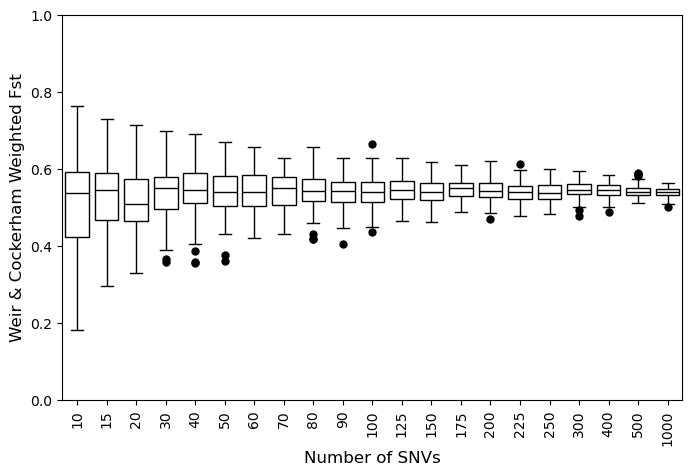

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot grouped by 'n_snvs' using 'fst' as values
tmp_df = fst_df.loc[(fst_df["comp"] == "shae_v_sbov") & (fst_df["n_snvs"] >= 10)]

plt.figure(figsize=(8, 5))
sns.boxplot(x="n_snvs", 
            y="fst", 
            data=tmp_df,
            zorder=2, 
            color = "white", 
            linewidth=1, 
            linecolor="black", 
            flierprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=5, linewidth=0.01)
           )

# Add horizontal line at 0.80617
# plt.axhline(y=0.54426, color='red', linestyle='--', linewidth=2, zorder=1)

#set ylims
plt.ylim(0, 1)


# Set labels and title
plt.xlabel("Number of SNVs", fontsize=12)
plt.xticks(rotation=90)
plt.ylabel("Weir & Cockerham Weighted Fst", fontsize=12)

# Save the figure
plt.savefig("all.sh_vs_sb.fst.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig("all.sh_vs_sb.fst.svg")

# Show the plot
plt.show()

In [279]:
fst_labels={
    'global': "Global", 
    'north_v_sbov': "North vs Sbo", 
    'shae_v_sbov': "Sha vs Sbo", 
    'south_v_north': "South vs North",
    'south_v_sbov': "South vs Sbo",
}

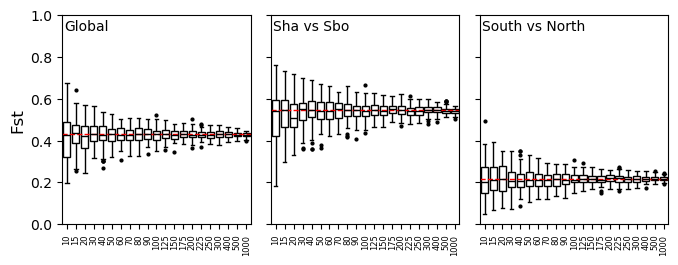

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Get unique comparisons
# comps = fst_df["comp"].unique()
comps = ["global", "shae_v_sbov", "south_v_north"]

# Create a 2x3 subplot grid
fig_width = 175 / 25.4  # 6.89 inches
fig_height = 70 / 25.4  

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(fig_width, fig_height), sharey=True)

# Flatten axes for easier indexing
axes = axes.flatten()

# Get panel labels: A, B, C, ...
panel_labels = list(string.ascii_uppercase)

# Loop through comparisons and plot boxplots
for i, comp in enumerate(comps):
    ax = axes[i]
    tmp_df = fst_df.loc[(fst_df["comp"] == comp) & (fst_df["n_snvs"] >= 10)]

    # Plot boxplot
    sns.boxplot(
        x="n_snvs",
        y="fst",
        data=tmp_df,
        ax=ax,
        zorder=2,
        color="white",
        linewidth=1,
        linecolor="black",
        flierprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=2, linewidth=0.01)
    )

    # Set axis labels and ticks
    ax.set_ylim(0, 1)
    ax.set_xlabel("Number of SNVs", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Fst", fontsize=12)
    # ax.set_title(comp, fontsize=12)
    ax.tick_params(axis='x', rotation=90)

    # Ensure all x-tick labels are present (explicitly)
    xtick_labels = sorted(tmp_df["n_snvs"].unique())
    ax.set_xticks(range(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, fontsize=6)

    #plot a horizontal line at the fst from all the data
    ax.axhline(y=true_fsts[comp], color='red', linestyle='--', linewidth=1)

    # Add panel label in upper left corner
    ax.text(
        0.01, 0.98,
        f"{fst_labels[comp]}",
        transform=ax.transAxes,
        fontsize=10,
        va="top",
        ha="left"
    )

# Remove unused subplots if fewer than 6 comparisons
for j in range(len(comps), 3):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig("fst.multipanel.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig("fst.multipanel.svg")

# Show figure
plt.show()


# get pi each data set and compare to whole genome

In [221]:
Path(f"{results_dir}/pi").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/pi")

In [222]:
#].to_csv("samples.include.list", sep=",", header=False, index=False)
popmap = info_df.loc[info_df["Final SNV Dataset"] == True, ["Library ID", "Population Assignment"]]

popmap['Population Assignment'] = popmap['Population Assignment'].replace({
    'S. haematobium (southern)': 'south',
    'S. haematobium (northern)': 'north',
    'S. bovis': 'sb'
})

popmap.to_csv("popmap.tsv", sep=",", header=False, index=False)
popmap

,Library ID,Population Assignment
0,angola_cota_57,south
1,angola_cota_58,south
2,angola_cota_59,south
3,angola_icau_60,south
4,angola_icau_61,south
...,...,...
205,unguja_kinyasini_30,south
209,margrebowiei_zambia_ERR310940,Na
211,zambia_kafue_71,south
212,zambia_lishiko_66,south


In [225]:
import glob
import pandas as pd
import allel

In [226]:
import glob
import pandas as pd
import allel

# Prepare result list
results = []

# Get VCF files
vcf_files = glob.glob(f"{results_dir}/subsample_snvs/*.vcf")

for vcf_file in vcf_files:

    # Load VCF
    callset = allel.read_vcf(vcf_file, fields=['samples', 'calldata/GT', 'variants/POS'])

    # Match VCF samples with population assignments
    vcf_samples = list(callset['samples'])
    popmap_filtered = popmap[popmap['Library ID'].isin(vcf_samples)]
    sample_to_pop = dict(zip(popmap_filtered['Library ID'], popmap_filtered['Population Assignment']))

    # Group sample indices by population
    subpops = {}
    for pop in popmap_filtered['Population Assignment'].unique():
        subpops[pop] = [i for i, s in enumerate(vcf_samples) if sample_to_pop.get(s) == pop]

    # Genotypes
    gt = allel.GenotypeArray(callset['calldata/GT'])

    # Calculate π per population
    pi_dict = {}
    for pop, indices in subpops.items():
        ac_sub = gt.take(indices, axis=1).count_alleles()
        pi = allel.sequence_diversity(callset['variants/POS'], ac_sub)
        pi_dict[f'pi_{pop}'] = pi

    # Store result
    row = {'file': vcf_file}
    row.update(pi_dict)
    results.append(row)

# Create results DataFrame
df_results = pd.DataFrame(results)

# Show and/or save
print(df_results)
df_results.to_csv("pi_summary.csv", index=False)

AttributeError: module 'allel' has no attribute 'read_vcf'

# Run admixuture on desired number of 

In [41]:
Path(f"{results_dir}/admixture").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/admixture")

In [42]:
procrustes_df.loc[procrustes_df.loc[procrustes_df["n_snvs"] == 250, "procrustes_distance"].idxmin()]

snv_type                    all
n_snvs                      250
replicate                    72
procrustes_distance    0.012691
t0_similarity          0.993634
Name: 372, dtype: object

In [54]:
procrustes_df.loc[procrustes_df.loc[procrustes_df["n_snvs"] == 500, "procrustes_distance"].idxmin()]

snv_type                    all
n_snvs                      500
replicate                    83
procrustes_distance    0.006651
t0_similarity          0.996669
Name: 283, dtype: object

In [ ]:
# all.subsample_n250_rep72.vcf
# all.subsample_n500_rep83.vcf

In [292]:
%%bash

conda run -n plink --cwd . \
    plink \
        --vcf ../subsample_snvs/all.subsample_n250_rep72.vcf \
        --out all.subsample \
        --double-id \
        --recode12 \
        --allow-extra-chr

PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
urcell, Christopher Chang   GNU General Public License v3
recode 12 ...".2 flag deprecated.  Use "--
Logging to all.subsample.log.
Options in effect:
  --allow-extra-chr
  --double-id
 --out all.subsample
  --recode 12
  --vcf ../subsample_snvs/all.subsample_n250_rep72.vcf

B RAM detected; reserving 515643 MB for main workspace.

bsample-temporary.bim +mporary.bed + all.su
all.subsample-temporary.fam written.
250 variants loaded from .bim file.
 people (0 males, 0 females, 162 ambiguous) loaded from .fam.
mple.nosex .x IDs written to all.subsa
Using 1 thread (no multithreaded calculations invoked).
2 founders and 0 nonfounders present.
Calculating allele frequencie done.
Total genotyping rate is 0.82516.
riants and 162 people pass filters and QC.
Note: No phenotypes present.
e.ped + all.subsample.map done.



In [299]:
%%bash

conda run -n popgen --cwd . bcftools query -l ../subsample_snvs/all.subsample_n250_rep72.vcf | head -n -1 >all.subsample.samples.list

In [294]:
%%bash

conda run -n popgen --cwd . --live-stream \
    admixture \
        --cv=1000 \
        -j12 \
        all.subsample.ped \
        2 \
        >all.subsample.k2.log

In [303]:
# Read in samples
with open("all.subsample.samples.list", 'r') as f:
    samples = f.read().splitlines()

# Get relevant sample info
info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)

In [309]:
adm_df

,0,1,sample_name,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,0.00001,0.99999,cdivoire_foro_106,cdivoire_foro_106,MCF603C280410,S. bovis,S. bovis,S. bovis,SRR11907395,Herein,...,cercariae,cercariae,64.8,31.12,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Nat...,NaN
1,0.00001,0.99999,cdivoire_foro_116,cdivoire_foro_116,MCFEDA1E10304,S. bovis,S. bovis,S. bovis,SRR11907384,Herein,...,cercariae,cercariae,57.3,28.28,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN
2,0.00001,0.99999,cdivoire_noumousso_107,cdivoire_noumousso_107,MCF603C280411,S. bovis,S. bovis,S. bovis,SRR11907394,Herein,...,cercariae,cercariae,70.7,33.43,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Nat...,NaN
3,0.00001,0.99999,cdivoire_noumousso_117,cdivoire_noumousso_117,MCFEDA1E10311,S. bovis,S. bovis,S. bovis,SRR11907383,Herein,...,cercariae,cercariae,107.1,51.79,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN
4,0.00001,0.99999,cdivoire_foro_101,cdivoire_foro_101,MCF28EEAF0338,S. bovis,S. bovis,S. bovis,SRR11907401,Herein,...,cercariae,cercariae,76.1,18.81,True,NaN,3.95%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.99999,0.00001,unguja_kinyasini_26,unguja_kinyasini_26,MCF9796880043,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907466,Herein,...,miracidia,miracidia,39.9,15.77,True,NaN,100.00%,SCAN,ZEST (Mtumweni Ali Muhsin),NaN
158,0.99999,0.00001,unguja_kinyasini_27,unguja_kinyasini_27,MCF9796880045,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907464,Herein,...,miracidia,miracidia,41.8,18.68,True,NaN,100.00%,SCAN,ZEST (Mtumweni Ali Muhsin),NaN
159,0.99999,0.00001,unguja_kinyasini_28,unguja_kinyasini_28,MCF9796880046,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907463,Herein,...,miracidia,miracidia,36.8,14.60,True,NaN,100.00%,SCAN,ZEST (Mtumweni Ali Muhsin),NaN
160,0.99999,0.00001,unguja_kinyasini_29,unguja_kinyasini_29,MCF9796880047,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907462,Herein,...,miracidia,miracidia,40.8,18.12,True,NaN,100.00%,SCAN,ZEST (Mtumweni Ali Muhsin),NaN


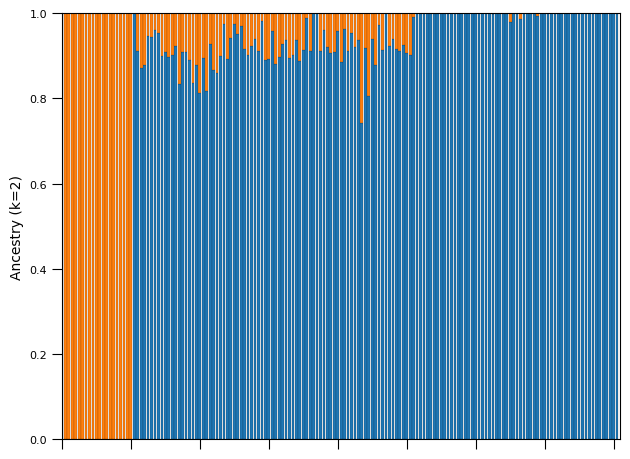

In [322]:
# For k in ks:

k=2

# Set up figure
fig = plt.figure()

# Read admixture data
adm_df = pd.read_csv(f"all.subsample.{k}.Q", sep=" ", header=None)
adm_df["sample_name"] = samples

x = list(range(len(adm_df)))

# Merge the dataframes
adm_df = adm_df.merge(info_df, how="left", left_on="sample_name", right_on="Library ID")

# Sort and reset index
adm_df = adm_df.sort_values(by=["Predicted Species", "Population Assignment", "Country"]).reset_index(drop=True)
adm_df.to_csv(f"all.subsample.{k}.df.csv", sep=",", header=True, index=False)

# Plot bars
bottom = [0] * len(adm_df)
for p_comp in range(k):
    plt.bar(x, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.1)
    bottom = bottom + adm_df[p_comp]

# Add labels and layout settings
plt.ylabel(f"Ancestry (k={k})", fontsize=10)
plt.tight_layout()
plt.xlim(0, len(adm_df))
plt.ylim(0, 1)
plt.yticks(fontsize=8)
plt.tick_params(labelbottom=False, length=7)

# Save figures
plt.savefig(f"all.subsample.{k}.svg")
plt.savefig(f"all.subsample.{k}.png", facecolor="white", dpi=600, bbox_inches="tight")

# Display plot
plt.show()
plt.close()

In [314]:
%%bash

conda run -n plink --cwd . \
    plink \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --out scan \
        --double-id \
        --recode12 \
        --allow-extra-chr

PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
urcell, Christopher Chang   GNU General Public License v3
recode 12 ...".2 flag deprecated.  Use "--
Logging to scan.log.
Options in effect:
  --allow-extra-chr
  --double-id
an--out sc
  --recode 12
  --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf

 515643 MB for main workspace.ving

--vcf: 1k variants complete.
--vcf: 2k variants complete.
variants complete.
--vcf: 4k variants complete.
--vcf: 5k variants complete.
lete.: 6k variants comp
--vcf: 7k variants complete.
--vcf: 8k variants complete.
--vcf: 9k variants complete.
10k variants complete.
--vcf: 11k variants complete.
--vcf: 12k variants complete.
ts complete.arian
--vcf: 14k variants complete.
--vcf: 15k variants complete.
e.vcf: 16k variants complet
--vcf: 17k variants complete.
--vcf: 18k variants complete.
--vcf: 19k variants complete.
20k variants complete.
--vcf: 21k variants complete.
--vcf: 22k variants complete.
ts complete.arian
--vcf: 24k

In [316]:
%%bash

conda run -n popgen --cwd . bcftools query -l ../prep_vcf/scan_autosomes_maf05_ld.vcf | head -n -1 >scan.samples.list

In [317]:
%%bash

conda run -n popgen --cwd . --live-stream \
    admixture \
        --cv=1000 \
        -j12 \
        scan.ped \
        2 \
        >scan.k2.log

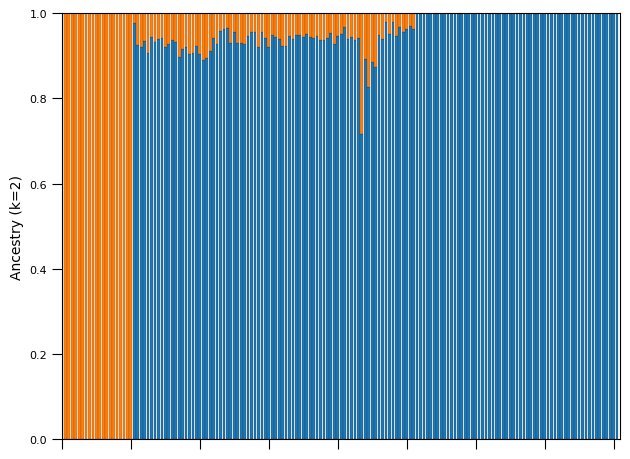

In [325]:
# For k in ks:

k=2

# Set up figure
fig = plt.figure()

# Read admixture data
adm_df = pd.read_csv(f"scan.{k}.Q", sep=" ", header=None)
adm_df["sample_name"] = samples

x = list(range(len(adm_df)))

# Merge the dataframes
adm_df = adm_df.merge(info_df, how="left", left_on="sample_name", right_on="Library ID")

# Sort and reset index
adm_df = adm_df.sort_values(by=["Predicted Species", "Population Assignment", "Country"]).reset_index(drop=True)
adm_df.to_csv(f"scan.{k}.df.csv", sep=",", header=True, index=False)

# Plot bars
bottom = [0] * len(adm_df)
for p_comp in range(k):
    plt.bar(x, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.1)
    bottom = bottom + adm_df[p_comp]

# Add labels and layout settings
plt.ylabel(f"Ancestry (k={k})", fontsize=10)
plt.tight_layout()
plt.xlim(0, len(adm_df))
plt.ylim(0, 1)
plt.yticks(fontsize=8)
plt.tick_params(labelbottom=False, length=7)

# Save figures
plt.savefig(f"scan.{k}.svg")
plt.savefig(f"scan.{k}.png", facecolor="white", dpi=600, bbox_inches="tight")

# Display plot
plt.show()
plt.close()

In [44]:
k=2
scan_df = pd.read_csv(f"scan.{k}.df.csv", sep=",", header=0)
sub_df = pd.read_csv(f"all.subsample.{k}.df.csv", sep=",", header=0)

scan_df.head()

,0,1,sample_name,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,0.00001,0.99999,cdivoire_foro_106,cdivoire_foro_106,MCF603C280410,S. bovis,S. bovis,S. bovis,SRR11907395,Herein,...,cercariae,cercariae,64.8,31.12,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Nat...,NaN
1,0.00001,0.99999,cdivoire_foro_116,cdivoire_foro_116,MCFEDA1E10304,S. bovis,S. bovis,S. bovis,SRR11907384,Herein,...,cercariae,cercariae,57.3,28.28,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN
2,0.00001,0.99999,cdivoire_noumousso_107,cdivoire_noumousso_107,MCF603C280411,S. bovis,S. bovis,S. bovis,SRR11907394,Herein,...,cercariae,cercariae,70.7,33.43,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Nat...,NaN
3,0.00001,0.99999,cdivoire_noumousso_117,cdivoire_noumousso_117,MCFEDA1E10311,S. bovis,S. bovis,S. bovis,SRR11907383,Herein,...,cercariae,cercariae,107.1,51.79,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN
4,0.00001,0.99999,cdivoire_foro_101,cdivoire_foro_101,MCF28EEAF0338,S. bovis,S. bovis,S. bovis,SRR11907401,Herein,...,cercariae,cercariae,76.1,18.81,True,NaN,3.95%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN


In [328]:
sub_df.head()

,0,1,sample_name,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,0.00001,0.99999,cdivoire_foro_106,cdivoire_foro_106,MCF603C280410,S. bovis,S. bovis,S. bovis,SRR11907395,Herein,...,cercariae,cercariae,64.8,31.12,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Nat...,NaN
1,0.00001,0.99999,cdivoire_foro_116,cdivoire_foro_116,MCFEDA1E10304,S. bovis,S. bovis,S. bovis,SRR11907384,Herein,...,cercariae,cercariae,57.3,28.28,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN
2,0.00001,0.99999,cdivoire_noumousso_107,cdivoire_noumousso_107,MCF603C280411,S. bovis,S. bovis,S. bovis,SRR11907394,Herein,...,cercariae,cercariae,70.7,33.43,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Nat...,NaN
3,0.00001,0.99999,cdivoire_noumousso_117,cdivoire_noumousso_117,MCFEDA1E10311,S. bovis,S. bovis,S. bovis,SRR11907383,Herein,...,cercariae,cercariae,107.1,51.79,True,NaN,0.00%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN
4,0.00001,0.99999,cdivoire_foro_101,cdivoire_foro_101,MCF28EEAF0338,S. bovis,S. bovis,S. bovis,SRR11907401,Herein,...,cercariae,cercariae,76.1,18.81,True,NaN,3.95%,SCAN,SCORE Cote D'Ivoire seasonal transmission (Cyr...,NaN


Slope: 1.0912, Intercept: 0.0064
R²: 0.7326, p-value: 1.205e-41


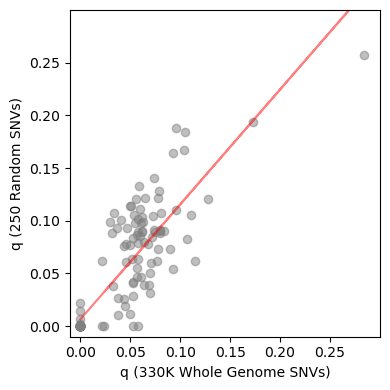

In [45]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define x and y
x = scan_df.loc[scan_df["Predicted Species"] == "S. haematobium", "1"]
y = sub_df.loc[sub_df["Predicted Species"] == "S. haematobium", "1"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Print summary
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")
print(f"R²: {r_value**2:.4f}, p-value: {p_value:.4g}")

# Plot
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=0.5, label="Data points", color="grey")

# Regression line
reg_line = slope * x + intercept
plt.plot(x, reg_line, color="red", label="Linear fit", alpha=0.5)

# Force same axis scale and range
plt.xlim(-.01, 0.3)
plt.ylim(-.01, 0.3)
# plt.gca().set_aspect("equal", adjustable="box")  # same physical size per unit

# # Optional: Set matching ticks manually if needed
ticks = [f"{v:.1f}" for v in np.arange(0, 0.4, 0.1)]

# get current tick locations from x-axis
plt.yticks(np.arange(0, 0.3, 0.05))        # apply them to y-axis
plt.xticks(np.arange(0, 0.3, 0.05))        # apply them to y-axis

# Labels
plt.xlabel("q (330K Whole Genome SNVs)")
plt.ylabel("q (250 Random SNVs)")

plt.tight_layout()
plt.show()


In [46]:
from scipy.stats import skew

residuals = y - x
residual_skew = skew(residuals)

print(f"Skew of residuals (y - x): {residual_skew:.4f}")


Skew of residuals (y - x): 0.5922


In [53]:
bias_mean = (y - x).mean()*100
bias_median = (y - x).median()*100
bias_mean

np.float64(0.9958276595744682)

In [51]:
(y-x).min()*100

np.float64(-5.8011)

In [52]:
(y-x).max()*100

np.float64(9.2731)

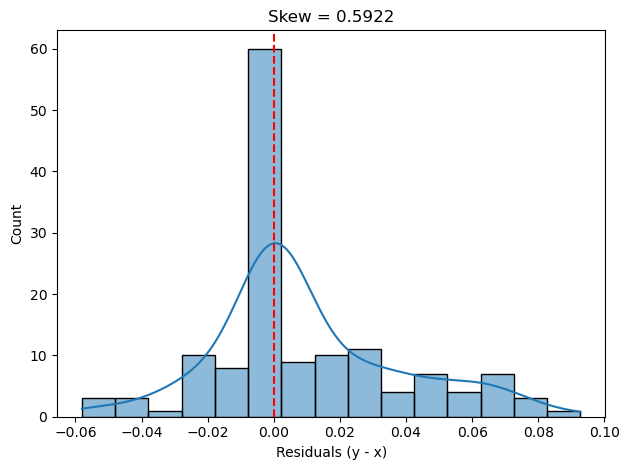

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(residuals, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (y - x)")
plt.title(f"Skew = {residual_skew:.4f}")
plt.tight_layout()
plt.show()


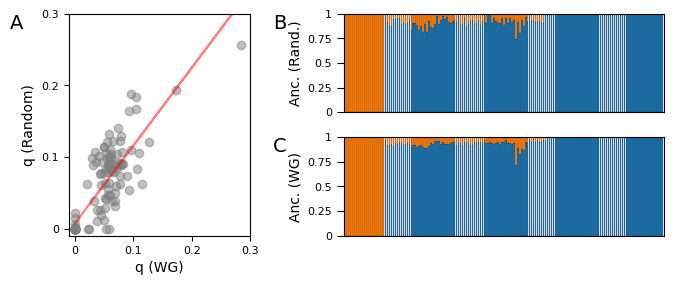

In [406]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from scipy.stats import linregress
import os

#get to appropriate dir
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"
os.chdir(f"{results_dir}/admixture")


# Setup main multipanel figure
width_mm = 175
height_mm = 75  # adjust as needed
fig = plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))
gs = gridspec.GridSpec(2, 5, figure=fig)

# ----------------- PCA Panel (Rows 0–1, Cols 0–1) -----------------
ax_pca = fig.add_subplot(gs[:, 0:2])

# PCA data
scan_df = pd.read_csv(f"scan.{k}.df.csv", sep=",", header=0)
sub_df = pd.read_csv(f"all.subsample.{k}.df.csv", sep=",", header=0)
x = scan_df.loc[scan_df["Predicted Species"] == "S. haematobium", "1"]
y = sub_df.loc[sub_df["Predicted Species"] == "S. haematobium", "1"]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
reg_line = slope * x + intercept

# Scatter Plot
ax_pca.scatter(x, y, alpha=0.5, label="Data points", color="grey")
ax_pca.plot(x, reg_line, color="red", alpha=0.5, label="Linear fit")
ax_pca.set_xlim(-0.01, 0.3)
ax_pca.set_ylim(-0.01, 0.3)
ax_pca.set_yticks([0, 0.1, 0.2, 0.3])
ax_pca.set_yticklabels(["0", "0.1", "0.2", "0.3"], fontsize=8)
ax_pca.set_xticks([0, 0.1, 0.2, 0.3])
ax_pca.set_xticklabels(["0", "0.1", "0.2", "0.3"], fontsize=8)
ax_pca.set_xlabel("q (WG)", fontsize=10)
ax_pca.set_ylabel("q (Random)", fontsize=10)

# ----------------- Admixture Plot 1 (Row 0, Cols 2–4) -----------------
ax_admix1 = fig.add_subplot(gs[0, 2:5])
k = 2
adm_df = pd.read_csv(f"all.subsample.{k}.Q", sep=" ", header=None)
adm_df["sample_name"] = samples
adm_df = adm_df.merge(info_df, how="left", left_on="sample_name", right_on="Library ID")
adm_df = adm_df.sort_values(by=["Predicted Species", "Population Assignment", "Country"]).reset_index(drop=True)
x = list(range(len(adm_df)))

bottom = [0] * len(adm_df)
for p_comp in range(k):
    ax_admix1.bar(x, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.1)
    bottom = np.array(bottom) + adm_df[p_comp]

ax_admix1.set_ylabel(f"Anc. (Rand.)", fontsize=10)
ax_admix1.set_xlim(0, len(adm_df))
ax_admix1.set_ylim(0, 1)
ax_admix1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax_admix1.set_yticklabels(["0", "0.25", "0.5", "0.75", "1"], fontsize=8)
ax_admix1.set_xticks([])
ax_admix1.set_xticklabels([])
# ax_admix1.set_title("Admixture: Subsample SNVs", fontsize=10)
ax_admix1.tick_params(labelbottom=False, length=5)

# ----------------- Admixture Plot 2 (Row 1, Cols 2–4) -----------------
ax_admix2 = fig.add_subplot(gs[1, 2:5])
adm_df2 = pd.read_csv(f"scan.{k}.Q", sep=" ", header=None)
adm_df2["sample_name"] = samples
adm_df2 = adm_df2.merge(info_df, how="left", left_on="sample_name", right_on="Library ID")
adm_df2 = adm_df2.sort_values(by=["Predicted Species", "Population Assignment", "Country"]).reset_index(drop=True)
x2 = list(range(len(adm_df2)))

bottom2 = [0] * len(adm_df2)
for p_comp in range(k):
    ax_admix2.bar(x2, adm_df2[p_comp], bottom=bottom2, edgecolor="black", linewidth=0.1)
    bottom2 = np.array(bottom2) + adm_df2[p_comp]

ax_admix2.set_ylabel(f"Anc. (WG)", fontsize=10)
ax_admix2.set_xlim(0, len(adm_df2))
ax_admix2.set_ylim(0, 1)
ax_admix2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax_admix2.set_yticklabels(["0", "0.25", "0.5", "0.75", "1"], fontsize=8)
ax_admix2.set_xticks([])
ax_admix2.set_xticklabels([])
# ax_admix2.set_title("Admixture: Whole Genome SNVs", fontsize=10)
ax_admix2.tick_params(labelbottom=False, length=5)

# ----------------- Label each plot -----------------
# Add panel label A (PCA)
ax_pca.text(-0.25, 1.0, "A", transform=ax_pca.transAxes,
            fontsize=14, va="top", ha="right")

# Add panel label B (Top Admixture)
ax_admix1.text(-0.18, 1.0, "B", transform=ax_admix1.transAxes,
               fontsize=14, va="top", ha="right")

# Add panel label C (Bottom Admixture)
ax_admix2.text(-0.18, 1.0, "C", transform=ax_admix2.transAxes,
               fontsize=14, va="top", ha="right")

# ----------------- Final Layout + Save -----------------
plt.tight_layout()
plt.savefig("multipanel_admixture.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.savefig("multipanel_admixture.svg", bbox_inches="tight", facecolor="white")
plt.savefig("multipanel_admixture.tiff", dpi=600, bbox_inches="tight")
plt.show()


# unused

In [29]:
#select either the top most informative variants across all PCS

n_snvs = 100_000
n_pcs = 5
pc_columns = [f'PC{i}' for i in range(1, n_pcs)]
load_df['PC_sum'] = load_df[pc_columns].sum(axis=1)

# Get the top X rows based on PC_sum
top = load_df.sort_values(by='PC_sum', ascending=False).head(n_snvs)
top["ID"].to_csv(f"top_variants.list", sep=",", header=True, index=False)

# max_pcs = 10
# n_snvs_per_pc = 10000

# %env MAX_PCS=$max_pcs
# %env N_SNVS=$n_snvs_per_pc

# # Dictionary to store top variants for each PC
# top_variants_per_pc = {}

# # Iterate over the first six PCs
# for i in range(1, max_pcs + 1):  # Assuming PCs start from column index 1
#     pc_name = f"PC{i}"  # Get column name for reference
#     top_variants_per_pc[pc_name] = load_df.nlargest(n_snvs_per_pc, pc_name)

# # Combine all selected variants into a single DataFrame
# top_variants_all_pcs = pd.concat(top_variants_per_pc.values()).drop_duplicates()

# top_variants_all_pcs.to_csv(f"top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.csv", sep=",", header=True, index=False)
# top_variants_all_pcs["ID"].to_csv(f"top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.list", sep=",", header=True, index=False)
# top_variants_all_pcs

In [30]:
%%bash

conda run -n popgen --cwd . --live-stream\
    vcftools \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --snps top_variants.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >top_variants.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--recode-INFO-all
	--recode
	--snps top_variants.list
	--stdout

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each ALT allele, 

In [31]:
%%bash

conda run -n popgen --cwd . --live-stream\
    plink2 \
        --threads 12 \
        --vcf top_variants.vcf \
        --pca 10 \
        --double-id \
        --allow-extra-chr \
        --out pca.top_variants

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to pca.top_variants.log.
n effect:
  --allow-extra-chr
  --double-id
  --out pca.top_variants
  --pca 10
  --threads 12
cf top_variants.vcf

Start time: Mon Mar 17 13:56:34 2025
le; reserving 515643 MiB for main5 availab
workspace.
Using up to 12 threads (change this with --threads).
--vcf: 100000 variants scanned.
--vcf: pca.top_variants-temporary.pgen + pca.top_variants-temporary.pvar.zst +
porary.psam written.
163 samples (0 females, 0 males, 163 ambiguous; 163 founders) loaded from
op_variants-temporary.psam.
100000 variants loaded from pca.top_variants-temporary.pvar.zst.
o phenotype data present.
done.lating allele frequencies... 0%
done.ructing GRM: 0%
done.cting for missingness... 0%
done.cting eigenvalues and eigenvectors... 
--pca: Eigenvectors written to pca.top_variants.eigenvec , and eigenvalues
variants.eigenval .
End time: Mon M

In [32]:
#get eigen values and sample labels
pca_top_pcs_df=pd.read_csv(f"pca.top_variants.eigenvec", sep="\t", header=0)
pca_top_pcs_df=pca_top_pcs_df.drop("#FID", axis=1)

#merge the dataframes
pca_top_pcs_df=pca_top_pcs_df.merge(info_df, how='left', left_on="IID", right_on='Library ID')
pca_top_pcs_df.to_csv(f"pca.top_variants.df.csv", sep=",", header=True, index=False)
# pca_top_pcs_df
